In [1]:

#imports
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier

#put in your path to the data set

train = pd.read_csv("/content/DataQuest Dataset - train_data.csv")
test = pd.read_csv(r"/content/DataQuest Dataset - test_data.csv")
#drop NaN values in train dataset
#test.isnull().sum()


In [2]:
#prepocessing
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# fit and transform the 'Meal Plan' column
encoded = encoder.fit_transform(train['MealPlan'])
encoded1 = encoder.fit_transform(test['MealPlan'])
encoded2 = encoder.fit_transform(train['RoomType'])
encoded3 = encoder.fit_transform(test['RoomType'])
encoded4 = encoder.fit_transform(train['MarketSegment'])
encoded5 = encoder.fit_transform(test['MarketSegment'])
encoded6 = encoder.fit_transform(train['BookingStatus'])
encoded7 = encoder.fit_transform(test['BookingStatus'])

# replace the original 'Meal Plan' column with the encoded values
train['MealPlan'] = encoded
test['MealPlan'] = encoded1
train['RoomType'] = encoded2
test['RoomType'] = encoded3
train['MarketSegment'] = encoded4
test['MarketSegment'] = encoded5
train['BookingStatus'] = encoded6
test['BookingStatus'] = encoded7

train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)


In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
train['CancelRatio'] = train['NumPrevCancellations'] / (train['NumPreviousNonCancelled'] + train['NumPrevCancellations'])
train['CancelRatio'] = train['CancelRatio'].replace(np.nan, 0)
train['NumGuests'] = train['NumAdults'] + train['NumChildren']
train['Nights'] = train['NumWeekendNights'] + train['NumWeekNights']
train['Price'] = train['Nights'] * train['AvgRoomPrice']


train['Date'] = pd.to_datetime(train['ArrivalYear'].astype(str) + '-' + train['ArrivalMonth'].astype(str).str.zfill(2) + '-' + train['ArrivalDate'].astype(str).str.zfill(2), errors='coerce')
cat_features = ['MealPlan', 'Parking', 'RoomType', 'MarketSegment', 'RepeatedGuest']


# create the transformer for one-hot encoding
# calculate number of days since first date
train = train.sort_values(by='Date')
first_date = train['Date'].iloc[0]
train['DaysSinceFirst'] = (train['Date'] - first_date).dt.days


train.replace([np.inf, -np.inf], np.nan, inplace=True)
train=train.dropna()
x = train.loc[:, (train.columns != 'BookingStatus') & (train.columns != 'BookingID') & (train.columns != 'Date')]
y = train.BookingStatus # Target variable
train.head()


,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,MealPlan,Parking,RoomType,...,NumPreviousNonCancelled,AvgRoomPrice,SpecialRequests,BookingStatus,CancelRatio,NumGuests,Nights,Price,Date,DaysSinceFirst
19497,19498,257,2017,7,1,0,2,1,0,0,...,0,101.5,0,0,0.0,2,2,203.0,2017-07-01,0
13198,13199,257,2017,7,1,0,2,1,0,0,...,0,101.5,0,0,0.0,2,2,203.0,2017-07-01,0
23194,23195,257,2017,7,1,0,2,1,0,0,...,0,80.0,0,1,0.0,1,2,160.0,2017-07-01,0
22967,22968,257,2017,7,1,0,2,1,0,0,...,0,101.5,0,0,0.0,2,2,203.0,2017-07-01,0
4103,4104,181,2017,7,1,1,4,0,0,0,...,0,111.5,0,0,0.0,3,5,557.5,2017-07-01,0


In [11]:
#test train and x,y split
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3, random_state=1)
CT = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_features)],remainder='passthrough')
x_train = CT.fit_transform(x_train)
x_test = CT.transform(x_test)


In [ ]:
# # define hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
#ignore this its for finding hyperparams
rf_model = RandomForestClassifier()
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(x_train, y_train)
print("Best hyperparameters: ", grid_search.best_params_)
print("Best performance score: ", grid_search.best_score_)

KeyboardInterrupt: ignored

In [12]:
# #random_state=42# best_model = grid_search.best_estimator_
# # y_pred = best_model.predict(x_test)

#optimal model
rf_model = RandomForestClassifier(
    max_features=None,
    bootstrap=True, 
    random_state=4, 
    min_samples_leaf=2,
    max_depth=10, 
    min_samples_split=2, 
    n_estimators=50,
    criterion='entropy',   
)

rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)


In [13]:
# accuracy
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred, average = "binary", pos_label=1)
recall_score(y_test, y_pred, pos_label=1)
f1_score(y_test, y_pred, pos_label=1)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8828331608600667
Recall: 0.9295702592087313
Precision: 0.8999504705299654
F1 Score: 0.9145205939099069


In [14]:
print (f'Train Accuracy - : {rf_model.score(x_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_model.score(x_test,y_test):.3f}')

Train Accuracy - : 0.895
Test Accuracy - : 0.883


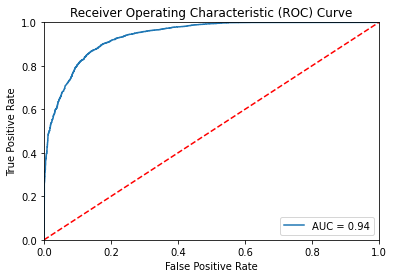

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

# make predictions on test data
y_pred_proba = rf_model.predict_proba(x_test)[:,1]

# calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# plot ROC curve
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
